In [9]:
from sklearn import preprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import nltk
import numpy as np

In [43]:
vector_size = 25
model = Doc2Vec.load("d2v_%i.model"%vector_size)

data = np.load('doc_to_vec_%i.npy'%vector_size)
data = preprocessing.normalize(data)
print(data.shape[0], data.min(), data.max(), data.mean(), data.std())

304713 -0.74979305 0.7984356 0.035318546 0.1968569


In [26]:
%matplotlib inline
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from IPython.core.display import Image, display


In [149]:
c = 3

In [150]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128, vector_size=100):
        super(generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        
        self.deconv1_2 = nn.ConvTranspose2d(vector_size, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        
        self.deconv4 = nn.ConvTranspose2d(d, c, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = self.deconv1_1(input)        
        x = self.deconv1_1_bn(x)
        x = F.relu(x)
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = self.deconv4(x)
        x = torch.tanh(x)
        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128, vector_size=100):
        super(discriminator, self).__init__()
        self.d = d
        self.conv1_1 = nn.Conv2d(c, int(d/2), 4, 2, 1)
        self.conv2 = nn.Conv2d(int(d/2), d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.fc1 = nn.Linear(d*4*4*4, 512)
        self.fc2 = nn.Linear(512, vector_size)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, noise_mult=6):
        
        rand = (torch.rand(*input.shape) - 0.5) * noise_mult
        input = torch.clamp(input + rand.cuda(), -1, 1)
        
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)

        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)

        x = x.view(self.d, self.d*4*4*4)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.tanh(x)
        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [151]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=1)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


In [152]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    G.eval()
    test_images = G(fixed_z, fixed_x)
    test_images = (test_images.cpu() + 1) * 0.5
    G.train()
    test_images = test_images[:100].data.view(100, c, 32, 32)
    save_image(test_images, path, nrow=20, padding=1, pad_value=1, scale_each=False, normalize=False)
    display(Image(path))

training start!
Starting 0
[1/14] - ptime: 14.45, loss_d: 0.00910634, loss_g: 0.00895068


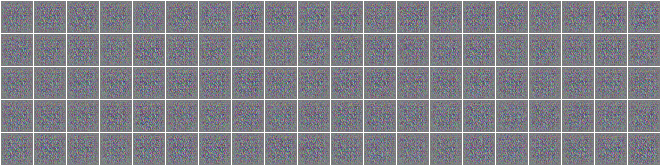

Starting 1
[2/14] - ptime: 14.41, loss_d: 0.00805997, loss_g: 0.00810146


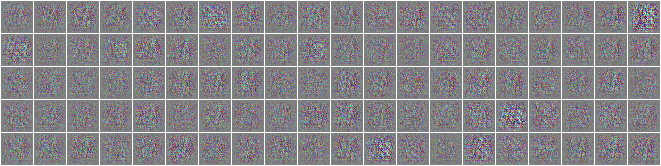

Starting 2
[3/14] - ptime: 14.40, loss_d: 0.00776459, loss_g: 0.00772460


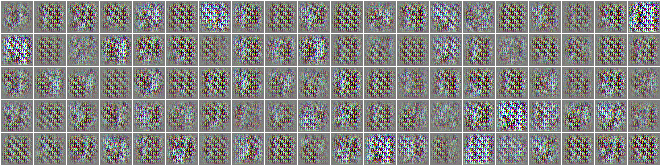

Starting 3
[4/14] - ptime: 14.41, loss_d: 0.00707928, loss_g: 0.00704986


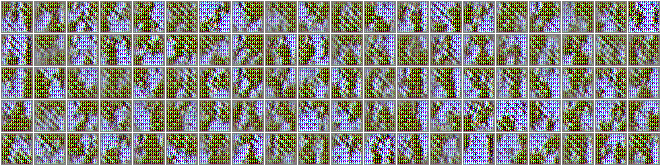

Starting 4
[5/14] - ptime: 14.39, loss_d: 0.00635146, loss_g: 0.00636193


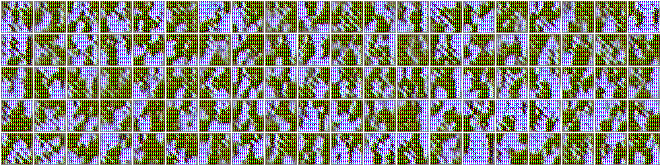

Starting 5
[6/14] - ptime: 14.41, loss_d: 0.00598908, loss_g: 0.00596430


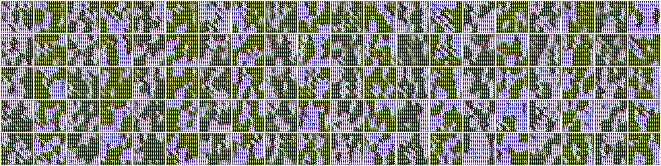

Starting 6
[7/14] - ptime: 15.94, loss_d: 0.00577589, loss_g: 0.00573403


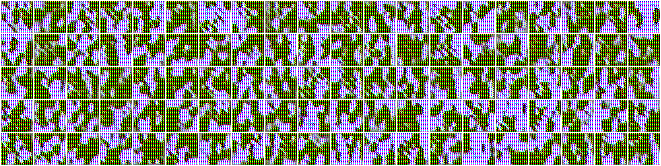

Starting 7
learning rate change!
[8/14] - ptime: 14.43, loss_d: 0.00559746, loss_g: 0.00564620


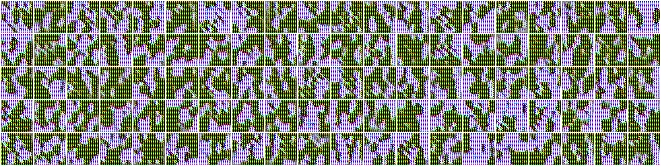

Starting 8
[9/14] - ptime: 14.41, loss_d: 0.00557451, loss_g: 0.00560957


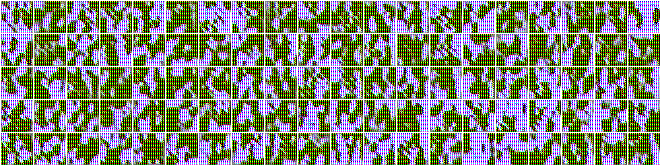

Starting 9
learning rate change!
[10/14] - ptime: 16.54, loss_d: 0.00557642, loss_g: 0.00557266


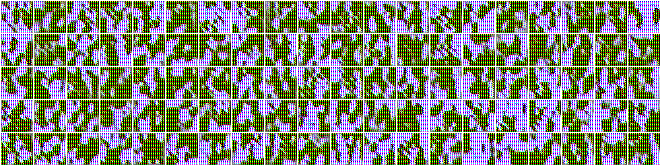

Starting 10
[11/14] - ptime: 14.43, loss_d: 0.00557443, loss_g: 0.00557074


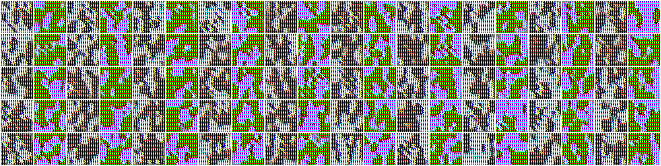

Starting 11
[12/14] - ptime: 14.41, loss_d: 0.00553933, loss_g: 0.00558987


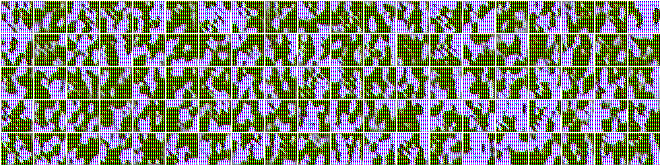

Starting 12


KeyboardInterrupt: 

In [153]:
# training parameters
batch_size = 128
lr = 0.0002 * .25
train_epoch = 14
noise = 25.0

# fixed noise & label
n_samples = 100
img_per_sample = 1

n_imgs = n_samples * img_per_sample

# Todo: refactor this madness
fixed_z = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()

a = np.random.randint(data.shape[0], size=(batch_size))
fixed_x = torch.from_numpy(data[a])
fixed_x.unsqueeze_(2)
fixed_x.unsqueeze_(3)
fixed_x = fixed_x.cuda()

# network
G = generator(128, vector_size=vector_size)
D = discriminator(128, vector_size=vector_size)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()

MSE_loss = nn.MSELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# results save folder
root = 'd2v_results/'
model_path = 'd2v_model_'

if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []


print('training start!')
start_time = time.time()

for epoch in range(train_epoch):
    print('Starting', epoch)
    D_losses = []
    G_losses = []

    # learning rate decay
    if (epoch+1) in [8, 10, 14]:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    epoch_start_time = time.time()
    
    for i in range(400):
        a = np.random.randint(data.shape[0], size=(batch_size))
        x = torch.from_numpy(data[a])
        x.unsqueeze_(2)
        x.unsqueeze_(3)
        x = x.cuda()

        # train discriminator D
        D.zero_grad()
        z = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()

        G_result = G(z, x)
        D_result = D(G_result, noise)
        
#         if i %200 == 0:
#             print(list(zip(x.squeeze().cpu().data[0, :10],
#                            D_result.squeeze().cpu().data[0, :10])))
#             print()
        
        D_loss = MSE_loss(D_result.squeeze(), x.squeeze())
        D_loss.backward()
        D_optimizer.step()
        D_losses.append(D_loss.item())
        
        ################################################################################################
        # train generator G
        G.zero_grad()
        a = np.random.randint(data.shape[0], size=(batch_size))
        x = torch.from_numpy(data[a])
        x.unsqueeze_(2)
        x.unsqueeze_(3)
        x = x.cuda()
        z = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()
    
        # Fake data loss.
        G_result = G(z, x)
        D_result = D(G_result, noise).squeeze()

        G_train_loss = MSE_loss(D_result, x.squeeze())
        
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f, loss_d: %.8f, loss_g: %.8f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    fixed_p = root + 'Fixed_results/' + model_path + str(epoch + 1) + '.png'
    show_result((epoch+1), show=True, path=fixed_p)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
print("Training finish!... save training results")
torch.save(G.state_dict(), root + model_path + 'generator_param.pkl')
torch.save(D.state_dict(), root + model_path + 'discriminator_param.pkl')
with open(root + model_path + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=root + model_path + 'train_hist.png')

images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model_path + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))

    imageio.mimsave(root + model_path + 'generation_animation.gif', images, fps=5)

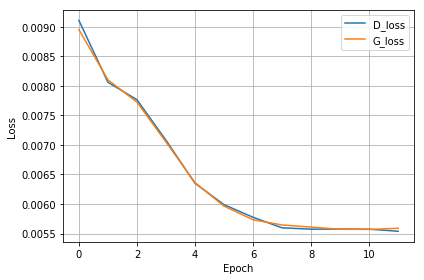

In [155]:
show_train_hist(train_hist, show=True, path=root + model_path + 'train_hist.png')

In [203]:
def show_sentence(text):
    model.random.seed(0)
    test_data = word_tokenize(text.lower())
    v1 = model.infer_vector(test_data)
    x = np.zeros((batch_size, vector_size), dtype='float32')
    x[0] = v1
    x = torch.from_numpy(x)
    x.unsqueeze_(2)
    x.unsqueeze_(3)
    x = x.cuda()
    G_result = G(fixed_z, x)
    test_images = (G_result.cpu() + 1) * 0.5
    test_images = test_images[:1].data.view(-1, c, 32, 32)
    save_image(test_images, './test.png', nrow=2, padding=1, pad_value=1, scale_each=False, normalize=False)
    display(Image('./test.png'))

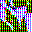

In [206]:
show_sentence('Uttering a word is like striking a note on the keyboard of the imagination')

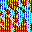

In [208]:
show_sentence('Uttering a word')

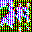

In [209]:
show_sentence('a word is like striking a note')

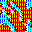

In [212]:
show_sentence('a note on the keyboard')

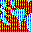

In [210]:
show_sentence('striking a note on the keyboard of the imagination')

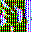

In [211]:
show_sentence('the keyboard of the imagination')